This example was taken from https://github.com/rtqichen/torchdiffeq and simplified

In [26]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# choose if you want to use adjoint method or normal backpropagation for training
from torchdiffeq import odeint_adjoint as odeint
#from torchdiffeq import odeint

In [35]:
data_size = 500
batch_time = 10
batch_size = 20
niters = 200

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define true values and time steps
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., 1000).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

# define true ODE
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

# calculate true trajectory
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

# split generated data into batches
def get_batch():
    # draw "batch_size" number of samples without replacement. These are indeces.
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    
    # get the data at these indeces. They will be starting values for the integration.
    batch_y0 = true_y[s]  # (M, D)
    
    # get first batch_time values from the time linspace t
    batch_t = t[:batch_time]  # (T)
    
    # start at the batch_y0s and add the next batch_time elements from the true y trajectory.
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# define the neural ODE
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # very simple just 2 layers
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        # initialise weights and biases around 0
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

# training loop
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

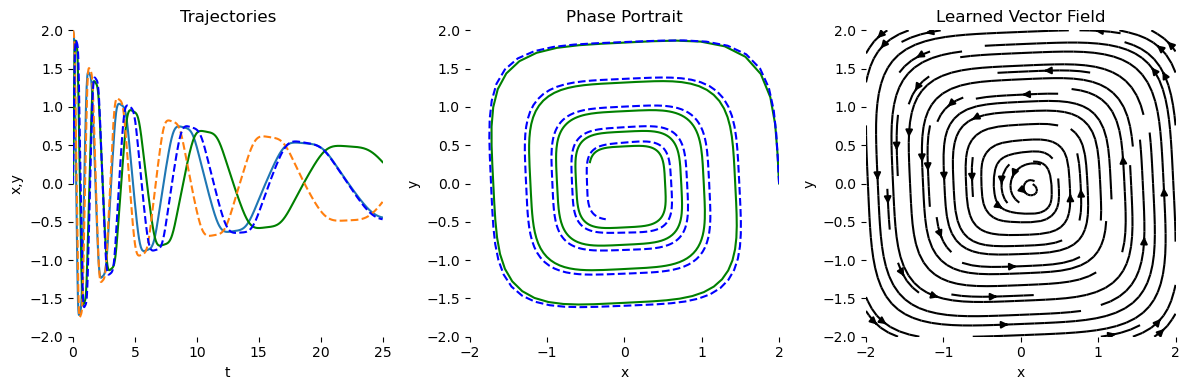

In [37]:
with torch.no_grad():    
    pred_y = odeint(func, true_y0, t)
    
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)
visualize(true_y, pred_y, func)
plt.show(block=False)

In [21]:
def visualize(true_y, pred_y, odefunc):
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-2, 2)

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2, 2)
    ax_phase.set_ylim(-2, 2)

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
    plt.draw()
    plt.pause(0.001)